## PoeML:  exploratory data analysis

**Description:** This notebook contains exploratory data analysis for the poems I scraped from the web.  It explores thematic grouping, sentiment analysis, and vector embeddings.  The goal of the analysis is to figure out a way to structure the picture-poem matching algorithm that I want for my photobooking app.

### <p style="color: green"> Contents:</p>
1.  <a href='#dataselection'> Data selection </a>
2.  <a href='#datapreparation'> Data preparation </a>

----

<a id='dataselection'></a>
### DATA SELECTION

Even though the data has already been given a surface cleaning, it remains to pick and choose what poems we wish to use for our application, and flag any pathologies.  This section performs these tasks.     

**Path and file names**

In [124]:
pklpath = '../data/poems/pkl'    # root path where data is stored
csvpath = '../data/poems/csv'
df_name1 = 'famouspoets'          # root names of poetry collections
df_name2 = 'poetsorg'
df_name3 = 'top100'
version  = 'clean'                # load this version of the poems

**Import statements**

In [101]:
# standard python packages
import pandas as pd
import numpy as np
import pickle, csv, re, string, time
import glob, sys 
import IPython as IP
import re, os, io

# language processing packages
import nltk
import spacy
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from textblob import TextBlob

# database packages
import sqlalchemy # pandas-mysql interface library
import sqlalchemy.exc # exception handling

# various sci-kit learn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, spectral_clustering
from sklearn.preprocessing import normalize
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

# plotting functionality
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# google api
from google.cloud import vision
from google.cloud.vision import types
from PIL import Image, ImageDraw

**Load and view the data**

There are three datasets, one from "famouspoetsandpoems.com" (~34000 poems), one from "poets.org" (~6000 poems) and one from "poetrysoup.com" (100 poems.)  

In [102]:
exec('df1' + "= pd.read_pickle('" + pklpath + '/' + df_name1 + '_' + version + ".pkl')")
exec('df2' + "= pd.read_pickle('" + pklpath + '/' + df_name2 + '_' + version + ".pkl')")
exec('df3' + "= pd.read_pickle('" + pklpath + '/' + df_name3 + '_' + version + ".pkl')")

In [103]:
n1 = len(df1)
n2 = len(df2)
n3 = len(df3)
print('{} poems in df1'.format(n1))
IP.display.display(df1[0:2])
print('{} poems in df2'.format(n2))
IP.display.display(df2[0:2])
print('{} poems in df3'.format(n3))
IP.display.display(df3[0:2])

34270 poems in df1


,url,title,author,themes,poem,number,birth,death,length
0,http://www.famouspoetsandpoems.com/poets/ezra_...,Cantico del Sole,Ezra Pound,NaN,The thought of what America would be like If t...,71,1885,1972,91
1,http://www.famouspoetsandpoems.com/poets/ezra_...,Taking Leave of a Friend,Ezra Pound,NaN,"Blue mountains to the north of the walls, Whit...",71,1885,1972,60


5382 poems in df2


,url,year,title,author,poem,themes,length
0,https://www.poets.org/poetsorg/poem/dark-tree-...,2017.0,"the dark tree, the cold sea",Emily Fragos,although I know you can never be found althoug...,[Afterlife],108
1,https://www.poets.org/poetsorg/poem/populating...,2008.0,Populating Heaven,Maureen N. McLane,"If we belonged to the dead, if we had our ow...",[Afterlife],253


100 poems in df3


,url,title,author,poem,length
0,https://www.poetrysoup.com/famous/poem/im_nobo...,Im nobody! Who are you?,Emily Dickinson,"I'm nobody! Who are you? Are you nobody, too?...",44
1,https://www.poetrysoup.com/famous/poem/the_les...,The Lesson,Maya Angelou,"I keep on dying again. Veins collapse, openin...",56


Clearly there are different bits of information for each data set.  For purposes of poem recommendation, I figure it's best to focus on relatively modern poems, and also short poems. Rather arbitrarily, I'll define "relatively modern" as meaning that the author was born after 1900 and I'll define "short" as meaning "less than 100 words."  Here I'll compile a database of poems that meet these criteria.  (Note that the poems in the third data frame are undated, but they are all very popular, and since the object of the app is to please, I'll include them too.)

**Select recent poems**

In [104]:
# include Frost and Dickinson because...well, because I love them.
df1 = df1.loc[(df1.birth>1900) | (df1.author=='Robert Frost') |(df1.author=='Emily Dickinson'),:]
df1 = df1.loc[(df1.author!='Raymond A. Foss'),:] # Raymond Foss's poems are a mess
df2 = df2.loc[(df2.year>1918),:]  # this publication is about the earliest possible for a birthdate >1900
df3 = df3
print('cut out {} poems from df1'.format(n1-len(df1)))
print('cut out {} poems from df2'.format(n2-len(df2)))

cut out 27515 poems from df1
cut out 928 poems from df2


**Select short poems**

In [105]:
df1 = df1.loc[df1.length<=100,:]
df2 = df2.loc[df2.length<=100,:]
df3 = df3.loc[df3.length<=100,:]
print("{} poems left.".format(len(df1)+len(df2)+len(df3)))

4271 poems left.


We'll use these remaining poems as our basic "dataset".  Let's group them together, including only poem, author, title, url, length, and theme.  

In [106]:
df3.insert(loc=len(df3.columns),column='themes',value=np.empty(len(df3))*np.nan)
df3.head()

,url,title,author,poem,length,themes
0,https://www.poetrysoup.com/famous/poem/im_nobo...,Im nobody! Who are you?,Emily Dickinson,"I'm nobody! Who are you? Are you nobody, too?...",44,NaN
1,https://www.poetrysoup.com/famous/poem/the_les...,The Lesson,Maya Angelou,"I keep on dying again. Veins collapse, openin...",56,NaN
2,https://www.poetrysoup.com/famous/poem/the_pow...,The Power of a Smile,Tupac Shakur,The power of a gun can kill and the power of ...,53,NaN
3,https://www.poetrysoup.com/famous/poem/a_total...,a total stranger one black day,Edward Estlin (E E) Cummings,a total stranger one black day knocked living...,31,NaN
4,https://www.poetrysoup.com/famous/poem/i_float...,"I float like a butterfly, sting like a bee",Muhammad Ali,"I float like a butterfly, sting like a bee",9,NaN


In [107]:
df_poems = pd.concat([df1[['poem','author','title','length','themes','url']],\
                      df2[['poem','author','title','length','themes','url']],\
                      df3[['poem','author','title','length','themes','url']]])
df_poems.head()

,poem,author,title,length,themes,url
136,It has a hole in it. Not only where I ...,Jorie Graham,The Surface,99,NaN,http://www.famouspoetsandpoems.com/poets/jorie...
163,The Sea Is History,Derek Walcott,The Sea Is History,4,"[history, sea]",http://www.famouspoetsandpoems.com/poets/derek...
164,Broad sun-stoned beaches. White heat. A green...,Derek Walcott,"Midsummer, Tobago",36,NaN,http://www.famouspoetsandpoems.com/poets/derek...
165,"The time will come when, with elation you wi...",Derek Walcott,Love After Love,98,NaN,http://www.famouspoetsandpoems.com/poets/derek...
177,This coral's hape ecohes the hand It hollowed....,Derek Walcott,Coral,84,NaN,http://www.famouspoetsandpoems.com/poets/derek...


Looks pretty good, but that poem by Walcott is suspicious:  let's take a look at other ridiculuously short poems and see if they are indeed kosher.

In [108]:
df_poems.loc[df_poems.length<25,:]

,poem,author,title,length,themes,url
163,The Sea Is History,Derek Walcott,The Sea Is History,4,"[history, sea]",http://www.famouspoetsandpoems.com/poets/derek...
657,We real cool. We Left School. We Lurk late. W...,Gwendolyn Brooks,We Real Cool,24,NaN,http://www.famouspoetsandpoems.com/poets/gwend...
809,Unfortunately this poem has been removed from ...,Raymond Carver,The Current,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
810,Unfortunately this poem has been removed from ...,Raymond Carver,Late Fragment,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
811,Unfortunately this poem has been removed from ...,Raymond Carver,An Afternoon,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
812,Unfortunately this poem has been removed from ...,Raymond Carver,Bobber,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
813,Unfortunately this poem has been removed from ...,Raymond Carver,The Scratch,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
814,Unfortunately this poem has been removed from ...,Raymond Carver,Drinking While Driving,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
815,Unfortunately this poem has been removed from ...,Raymond Carver,The Cobweb,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...
816,Unfortunately this poem has been removed from ...,Raymond Carver,The Best Time Of The Day,16,NaN,http://www.famouspoetsandpoems.com/poets/raymo...


Some missing poems by Carver.  Let's get rid of them.

In [116]:
df_poems.reset_index(inplace=True,drop=True)
df_poems = df_poems.loc[~df_poems.poem.str.contains("Unfortunately this poem has been removed"),:]
df_poems.loc[df_poems.length<25,:]

,poem,author,title,length,themes,url
1,The Sea Is History,Derek Walcott,The Sea Is History,4,"[history, sea]",http://www.famouspoetsandpoems.com/poets/derek...
28,We real cool. We Left School. We Lurk late. W...,Gwendolyn Brooks,We Real Cool,24,NaN,http://www.famouspoetsandpoems.com/poets/gwend...
35,The star in my Hand is falling All the unifor...,W. S. Merwin,Wish,23,NaN,http://www.famouspoetsandpoems.com/poets/w__s_...
130,"I could bend and kiss them, everyone, Strong ...",Barry Tebb,KISSING COBBLESTONES IN KEIGHLEY,16,NaN,http://www.famouspoetsandpoems.com/poets/barry...
138,Yellow rapeseed Fields of vision Whiter than...,Barry Tebb,TEXTPOEM,11,NaN,http://www.famouspoetsandpoems.com/poets/barry...
140,"Too much gone wrong No Muse, no song.",Barry Tebb,UPON BEING ASKED WHY I AM NOT WRITING,8,NaN,http://www.famouspoetsandpoems.com/poets/barry...
143,"Go seek Prince Charming in another place, His...",Barry Tebb,LETTER I,24,NaN,http://www.famouspoetsandpoems.com/poets/barry...
152,for Brenda Your blue dressing-gown Lying ...,Barry Tebb,TOGETHER,14,NaN,http://www.famouspoetsandpoems.com/poets/barry...
161,sleep patterns shifting-down late up early int...,Wanda Phipps,Morning Poem #39,8,NaN,http://www.famouspoetsandpoems.com/poets/wanda...
162,forever in bed waiting for heat luring black c...,Wanda Phipps,Morning Poem #59,12,NaN,http://www.famouspoetsandpoems.com/poets/wanda...


OK, these look like legitimate short poems.  Onward!  Quick check to see the distribution of poem sizes in the set that remains:

Total  number of poems:  4060


(array([ 44., 245., 379., 443., 615., 407., 398., 497., 504., 528.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

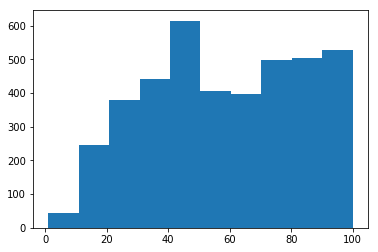

In [123]:
print('Total  number of poems: ',len(df_poems))
plt.hist(df_poems.length)

Let's go ahead and save this dataframe for future reference.

In [126]:
df_poems.to_csv(csvpath + '/' + 'poems_for_app.csv')
df_poems.to_pickle(pklpath + '/' + 'poems_for_app.pkl')

<a id="datapreparation"></a>
### DATA PREPARATION


I'll be implementing a couple of matching algorithms, and ultimately trying to return a poem that matches well with the syntactical queues from photos.  We'll need to keep the dataframe with the original poems around because it contains the nicely formatted text to be returned, but the matching will require that we strip, lemmatize, tokenize, etc. 

**Define custom cleaning functions**

In [131]:
# borrow parser from spacy
parser = spacy.load('en')

In [132]:
# A custom stoplist
STOPLIST = stopwords.words('english')
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + \
          ["-----", "--", "---", "...", "“", "”", "'s"] + list(string.digits)

In [133]:
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [134]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    
    
    # import a dictionary of English contractions from another file
    from contractions import contractions_dict
    
    # replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction.lower(),expansion.lower())
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ").replace("-"," ").replace("\'st"," ")
    text = re.sub("[0-9]"," ",text)
    text = re.sub("-", " ",text)
    
    # lowercase
    text = text.lower()

    return text

In [135]:
# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() 
                      if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")
    
    
    return tokens

**Vectorize the data with the help of these functions**

Here we put all the cleaning together to create a Tf-idf weighted bag of words.  

In [137]:
# the data is a pd.Series of strings.
data=df_poems.poem

# the number of distinct words to train on 
n_features  = 1000

# Use tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=n_features,
                             tokenizer=tokenizeText,
                             stop_words='english')

# the pipeline allows us to clean and vectorize in one fell swoop
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer)])

# term-document matrix
data_vectorized = pipe.fit_transform(data)

### Data Clustering

**NMF**:  Non-negative matrix factorization is one of two or three obvious algorithmic choices for thematic clustering.  I'm curious to know what themes these poems contain, and whether or not they'll be pronounced enough that the theme itself can help in the matching algorithm.

In [160]:
#define the number features, topics, and how many words/documents to display later on
n_topics        = 8
n_top_words     = 5
n_top_documents = 5
        
# use NMF model with the Frobenius norm
nmf = NMF(n_components=n_topics, random_state=1, 
          solver='mu', beta_loss='frobenius')

# carry out the factorization
W = nmf.fit_transform(data_vectorized)
H = nmf.components_
feature_names = vectorizer.get_feature_names()

It is also useful to cluster the documents by topics.  The topics are "discovered" and not necessarily easily intelligible.  Marginally useful.  But the following is a good go at it.

In [163]:
def display_topics(W, H, feature_names, data, n_top_words, n_top_documents):
    ''' Description:  Print out topics discovered by a model 
    
        Input:
            W,H  (positive matrices such that W*H ~ X, where X is bag-of-words matrix)
            feature_names  (list of feature names corresponding to columns of bag-of-words)
            data (pd.Series of poems, each poem corresponding to a row of W)
            n_top_words (scalar:  how many words to report)
            n_top_documents (scalar:  how many documents to report for each theme)
    '''
    
    feature_names = vectorizer.get_feature_names()
    
    for topic_id, topic in enumerate(nmf.components_):
        print('Topic #%02d: %s ' % (topic_id+1, ' '.join([str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]])))
        
        top_doc_indices = np.argsort( W[:,topic_id] )[::-1][0:n_top_documents]
        avg_polarity = 0
        for doc_index in top_doc_indices:
            doc = TextBlob(data.iloc[doc_index])
            avg_polarity += doc.sentiment[0]
            print('Line: {} (with polarity {}) \n'.format(data.iloc[doc_index], 
                                     doc.sentiment[0]))
            #print(df['reviewText'].iloc[doc_index]+"\n")
        print("Average polarity: %4.2f" % (avg_polarity / n_top_documents))
        print()
        

display_topics(W,H,feature_names, data, n_top_words, n_top_documents)

Topic #01: come light night eye day 
Line: Just past dawn, the sun stands with its heavy red head in a black stanchion of trees, waiting for someone to come with his bucket for the foamy white light, and then a long day in the pasture. I too spend my days grazing, feasting on every green moment till darkness calls, and with the others I walk away into the night, swinging the little tin bell of my name. (with polarity -0.07268518518518519) 

Line: i walk the dream where the street breathes in the shadow of moon-light, the lovers night.  oh, sweet love long time coming longer time whispering us free.  i sing your eyes as willows stretching into the ever passing winds  i speak the words of my heart i sing the songs of my dreams i see in the water your image and its true...  as i ride the butterfly, i offer the rose.                             - jude (with polarity 0.35833333333333334) 

Line: Three windows are at work here, sophisticated spaces against the day, against the light. The sky

In [164]:
text = "dog tree yellow road wood woman love"
x = vectorizer.transform([text])
print(x)
#%qtconsole

  (0, 996)	0.4144024185175719
  (0, 986)	0.42069889629955287
  (0, 984)	0.37125271724420744
  (0, 911)	0.30653366173984303
  (0, 689)	0.40206115417820754
  (0, 514)	0.26197756413582735
  (0, 234)	0.434978381679627


Note that the tf-idf weighting is included.  To get the names of the features, try this:

In [165]:
[feature_names[i] for i in x.indices]

['yellow', 'wood', 'woman', 'tree', 'road', 'love', 'dog']

## Visualization of topic clusters

In [23]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [24]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer)])
# grab term-document matrix
data_vectorized = pipe.fit_transform(data)

You can cluster the documents...

In [25]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

Or the words...

In [26]:
svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

We can also analyze the cluster composition of untrained text.  Two ways to proceed:  one, to figure out the closest topic, the other, to figure out the closest set of words in raw tf-idf space.  

In [27]:
text = "road grass woods yellow sdfjs fence"

# this x is just a row of word counts, using the 1000 features of the original fit.
x = vectorizer.transform([text])

In [28]:
data_vectorized.shape
nmf.components_.shape
transform.shape

(4192, 5)

In [29]:
from sklearn.metrics.pairwise import cosine_distances
 
def most_similar(x, Z, top_n=5):
    dists = cosine_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar

In [30]:
#x = nmf.transform(vectorizer.transform([text]))[0]
similarities = most_similar(x.toarray(), data_vectorized)
document_id, similarity = similarities[0]

print("original text:\n\n", x)
print("closest poem:\n\n", data[document_id][:1000])

original text:

   (0, 995)	0.42973806975105844
  (0, 984)	0.4403082928791041
  (0, 691)	0.42132011818571813
  (0, 373)	0.40660955026519324
  (0, 305)	0.5278369353063818
closest poem:

 Of Yellow was the outer Sky In Yellower Yellow hewn Till Saffron in Vermilion slid Whose seam could not be shewn.


In [31]:
# do the input and the output actually share any words in common?  Let's check.
feature_names = vectorizer.get_feature_names()
d=data_vectorized[document_id]
out_features = [feature_names[d.indices[i]] for i in np.arange(len(d.indices))]
in_features = [feature_names[x.indices[i]] for i in np.arange(len(x.indices))]
print("output features: ", out_features)
print("input features:  ", in_features)

output features:  ['slide', 'yellow', 'sky', 'till']
input features:   ['yellow', 'wood', 'road', 'grass', 'fence']


Note that there is no actual overlap on a "word by word" basis.  Let's see if we can do better with LDA.

## Now try LDA

First build and fit the model

In [32]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 5 
    
# Use tf-idf vectorizer
#vectorizer = TfidfVectorizer(min_df=0,max_df=1, max_features=n_features,
#                             preprocessor = cleanText,tokenizer=tokenizeText,
#                             stop_words='english',lowercase=True)

vectorizer = CountVectorizer(max_features=n_features,
                             tokenizer=tokenizeText,
                             stop_words='english')

# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')

# put it all in a pipeline
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer), ('lda', lda_model)])

# grab term-document matrix
transform = pipe.fit_transform(data)

Then process a random collection of keywords to see how it matches.

In [33]:
text = "road grass woods yellow sdfjs happy"
x = lda_model.transform(vectorizer.transform([text]))[0]
print(x, x.sum())

[0.03354622 0.53258257 0.03438417 0.03333357 0.36615347] 0.9999999999999999


Note that these number suggest this text is largely about topic 3.  Let's take a look at the "closest" poem, within the LDA projection scheme.

In [34]:
similarities = most_similar(x, transform)
document_id, similarity = similarities[0]

print("original text:\n\n", x)
print("closest poem:\n\n", data[document_id][:1000])

original text:

 [0.03354622 0.53258257 0.03438417 0.03333357 0.36615347]
closest poem:

 Unworthy of her Breast Though by that scathing test What Soul survive? By her exacting light How counterfeit the white We chiefly have!


Hmm...not obvious that there is a lot in common with this poem.  Let's check to see if there actually any feature words in common.  To do this we need the raw counter vector for the input, not the LDA projection.

In [35]:
# do the input and the output actually share any words in common?  Let's check.
feature_names = vectorizer.get_feature_names()
x=vectorizer.transform([text])
d=data_vectorized[document_id]
out_features = [feature_names[d.indices[i]] for i in np.arange(len(d.indices))]
in_features = [feature_names[x.indices[i]] for i in np.arange(len(x.indices))]
print("output features: ", out_features)
print("input features:  ", in_features)

output features:  ['light', 'white', 'breast', 'soul', 'test', 'survive']
input features:   ['grass', 'happy', 'road', 'wood', 'yellow']


In [36]:
display_topics(vectorizer, lda_model, transform, data, n_top_words, n_top_documents)

Topic #01: love know come day lose 
Line: What shall I do when the Summer troubles -- What, when the Rose is ripe -- What when the Eggs fly off in Music From the Maple Keep?  What shall I do when the Skies a'chirrup Drop a Tune on me -- When the Bee hangs all Noon in the Buttercup What will become of me?  Oh, when the Squirrel fills His Pockets And the Berries stare How can I bear their jocund Faces Thou from Here, so far?  'Twouldn't afflict a Robin -- All His Goods have Wings -- I -- do not fly, so wherefore My Perennial Things? (with polarity 0.275) 

Line: The Daisy follows soft the Sun -- And when his golden walk is done -- Sits shyly at his feet -- He -- waking -- finds the flower there -- Wherefore -- Marauder -- art thou here? Because, Sir, love is sweet!  We are the Flower -- Thou the Sun! Forgive us, if as days decline -- We nearer steal to Thee! Enamored of the parting West -- The peace -- the flight -- the Amethyst -- Night's possibility! (with polarity 0.438623046875) 

Li

Finally, let's inspect these categories with tsne plot

In [ ]:
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer)])
# grab term-document matrix
data_vectorized = pipe.fit_transform(data)

In [ ]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
#panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

## Lastly, let's try looking at cosine similarity simply within a non-reduced vectorization scheme.  

Let's just build a matrix of weighted counts.  Then we'll rewrite the similarity function to be the cosine distance within this big space.  Might be slow, we'll see.  But it will do a better job of word matching.

In [ ]:
data=df_poems.poem

# define the number features, topics, and how many 
# words/documents to display later on
n_features      = 1000
n_topics        = 5
n_top_words     = 5
n_top_documents = 5

# Use tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=n_features,
                             tokenizer=tokenizeText,
                             stop_words='english')

# put it all in a pipeline
pipe = Pipeline([('cleanText', CleanTextTransformer()), 
                 ('vectorizer', vectorizer)])

# form the word-poem matrix 
data_vectorized = pipe.fit_transform(data)

In [ ]:
# redefine the similarity function to deal with sparse vectors
def most_similar_nonreduced(x, data_vectorized, top_n=5):
    dists = np.dot(x,data_vectorized.T)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar


In [ ]:
text = "road grass woods yellow sdfjs"
x = vectorizer.transform([text])[0]
x

In [ ]:
text = "road grass woods yellow sdfjs"
x = vectorizer.transform([text])[0]
similarities = most_similar_nonreduced(x, data_vectorized)
document_id, similarity = similarities[0]

print("original text:\n\n", x)
print("closest poem:\n\n", data[document_id][:1000])

## Introduce sentiment analysis

In [ ]:
df_poems['sentiment'] = data.apply(lambda x : TextBlob(x).sentiment[0])

In [ ]:
text = "road grass woods yellow sdfjs nature say hope love"
TextBlob(text).sentiment[0]

In [ ]:
df_poems.head()

## Extracting top words from each poem

The Tf-idf weight scheme establishes a way to rank the importance of each words in each poem.  For purposes of embedding, we'll want to extract the top words from each poem.  The code below implements this idea

In [ ]:
# this is a tunable parameter.  each image gets 8-12 "labels" back, so we'll try to limit each poem to the same
ntopwords = 10
rank_idx = data_vectorized[10].data.argsort()[:-ntopwords:-1]
keywords = [feature_names[indices[i]] for i in rank_idx]
keywords

In [ ]:
feature_names = vectorizer.get_feature_names()

def extract_n_top_words_from_poem(poem_vector,feature_names):
    '''
    Description:  extract top words (in rank order) from each poem
    
    Input: a row of vectorized data (the result of a call to 'vectorizer.fit_transform') 
    Output:  a string of top words
    '''
    
    # adjust as necessary
    ntopwords = 10
    
    # rank keywords by tf-idf weight
    indices = row.indices
    rank_idx = poem_vector.data.argsort()[:-ntopwords:-1]
    
    # form list of such words and return it, along with weights
    keywords = [feature_names[indices[i]] for i in rank_idx]
    weights = [poem_vector.data[i] for i in rank_idx]

    return keywords, np.array(weights)

In [ ]:
kw,wt = extract_n_top_words_from_poem(data_vectorized[10], feature_names)
kw
wt

Let's extract top keyword for every poem in the data set

In [ ]:
words = []
weights = []
for row in data_vectorized:
    kw, wt = extract_n_top_words_from_poem(row,feature_names)
    words.append(kw)
    weights.append(wt)

In [ ]:
# store these results in our dataframe
df_poems['keywords']=words
df_poems['weights']=weights
df_poems.head()

In [ ]:
df_poems.to_pickle('df1_smallpoems.pkl')

## Pictures-to-words

I've been comparing poems to randomly invented strings of text.  In this section I record the functionality that will allow me to get words from pictures.  

In [ ]:
# first, we'll need to connect google-cloud-vision api
def explicit():
    from google.cloud import storage

    # Explicitly use service account credentials by specifying the private key
    # file.
    storage_client = storage.Client.from_service_account_json(
        '/Users/ctoews/Documents/Insight/Project/googleAPI/MyFirstProject-76680dcd1ad6.json')

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)
    
# authenticate google
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = \
"/Users/ctoews/Documents/Insight/Project/googleAPI/MyFirstProject-76680dcd1ad6.json"

explicit()

# instantiate a client
client = vision.ImageAnnotatorClient()
image = types.Image()

Now that we've connected, let's run some text images through the api and see what kind of labels we get back

In [ ]:
# The name of the image file to annotate
pathname = "/Users/ctoews/Documents/Insight/Project/data/photos/"
image_name = ["roads-diverging.jpg", "sunflower2.jpeg", "dogs2.jpg", "dogs3.jpg"]
file_names = [pathname + iname for iname in image_name]

# feed photo url to Google, extract label
all_labels = []

for file_name in file_names:
    
    # Loads the image into memory
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)
    
    # performs label detection
    response = client.label_detection(image=image)
    labels = response.label_annotations
    
    # stores label in list
    these_labels = ''
    for label in labels:
        these_labels += (label.description + ' ')
    all_labels.append(these_labels)

In [ ]:
all_labels

To make sure these images get mapped somewhere in the vicinity of the poems, let's us the same vectorizer to extract "top" words from each image.

In [ ]:
t=vectorizer.transform(pd.Series(all_labels))
image_words = []
image_weights = []
for row in t:
    kw, wt = extract_n_top_words_from_poem(row,feature_names)
    image_words.append(kw)
    image_weights.append(wt)

In [ ]:
df_images = pd.DataFrame({'keywords':image_words,'weights':image_weights})

In [ ]:
df_images['sentiment'] = [TextBlob(' '.join(x)).sentiment[0] for x in df_images.keywords]
df_images.head()

## Embed everything via word2vec

OK, now we have every poem and every picture reduced to top keywords, and we have also have sentiment analysis.  Let's embed everything into word2vec and hope for the best!

**Poem keywords first.** Calculate embedding vector for every keyword, and form a weighted sum.  Gather all results into a big array, and save.

**Warning:**  this cell is probably rather inefficiently implemented and takes a long time to run

In [ ]:
# spaCY's embedding vectors are all of length 384
poem_vectors = np.zeros((len(data),384))
j=0
for row in df_poems.itertuples():
    keywords = row.keywords
    weights = row.weights
    vecs = np.zeros((len(keywords),384))
    i = 0
    for key in keywords:
        vecs[i,:] = parser(key).vector
        i+=1
    poem_vectors[j,:]=np.dot(weights,vecs)    
    j+=1 

In [ ]:
vecs_d1_smallpoems = poem_vectors
pickle.dump(vecs_d1_smallpoems, open( "vecs_d1_smallpoems.pkl", "wb" ))

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
myPCA = PCA(n_components=2)
x= myPCA.fit_transform(vecs_d1_smallpoems)
plt.plot(x[:,0],x[:,1],'.b')
x1 = myPCA.transform(image_vectors)
plt.plot(x1[:,0],x1[:,1],'xr')

In [ ]:
x1 = myPCA.transform(image_vectors)
plt.plot(x1[:,0],x1[:,1],'xr')

**Image keywords next**

In [ ]:
# spaCY's embedding vectors are all of length 384
image_vectors = np.zeros((len(df_images),384))
j=0
for row in df_images.itertuples():
    keywords = row.keywords
    weights = row.weights
    vecs = np.zeros((len(keywords),384))
    i = 0
    for key in keywords:
        vecs[i,:] = parser(key).vector
        i+=1
    image_vectors[j,:]=np.dot(weights,vecs)    
    j+=1

**Does cosine similarity do anything for us here?**

In [ ]:
x=cosine_similarity(image_vectors,poem_vectors)
ix = x.argmax(axis=1)
plt.hist(x[3,:])
ix

In [ ]:
df_poems.loc[ix[1],'poem']

In [ ]:
im_sent = df_images['sentiment']
poem_sent = df_poems['sentiment']
x.shape
poem_sent.shape
t=np.array([(im_s - poem_sent) for im_s in im_sent])
t.shape

In [ ]:
def find_best_match(im_vec, poem_vec, im_sent, poem_sent, lam):
    """
    Description:  seeks to match one or more input image vectors to poem vectors with highest cosine similarity, regularized by differences in sentiment. 
    
    Input:  
        im_vec:  (n x 384) dimensional vector embedding of the n images
        poem_vec:   (m x 384) dimensional vector embedding of m poems
        im_sent (n x 1) vector of image sentiment analysis (each number between -1 and 1)
        poem_sent (mx1) vector of poem sentiment analysis (ditto)
        lam (scalar):  reglarization parameter.  
        
    Output:  indices of best matches, according the following objective function:
        f(i,p) = \| i_vec - p_vec \| - lam |i_sent - p_sent|
    """
    
    # assess the cosine similarity for each image/poem pair
    sim = cosine_similarity(im_vec,poem_vec) 
    
    # also calculate the difference in sentiment score
    dif = np.array([np.abs((im_s - poem_sent)) for im_s in im_sent])

    # the net score is a weighted difference
    net = sim - lam*dif
    
    ix = net.argmax(axis=1)
    return ix

In [ ]:
x=3
y=5
x+5

In [61]:
df1.head()

,url,title,author,themes,poem,number,birth,death,length
136,http://www.famouspoetsandpoems.com/poets/jorie...,The Surface,Jorie Graham,NaN,It has a hole in it. Not only where I ...,13,1950,2016,99
163,http://www.famouspoetsandpoems.com/poets/derek...,The Sea Is History,Derek Walcott,"[history, sea]",The Sea Is History,21,1930,2016,4
164,http://www.famouspoetsandpoems.com/poets/derek...,"Midsummer, Tobago",Derek Walcott,NaN,Broad sun-stoned beaches. White heat. A green...,21,1930,2016,36
165,http://www.famouspoetsandpoems.com/poets/derek...,Love After Love,Derek Walcott,NaN,"The time will come when, with elation you wi...",21,1930,2016,98
177,http://www.famouspoetsandpoems.com/poets/derek...,Coral,Derek Walcott,NaN,This coral's hape ecohes the hand It hollowed....,21,1930,2016,84
